In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [26]:
# Import libraries
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [42]:
# Import data
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print(train.shape, test.shape)

(42000, 785) (28000, 784)


In [43]:

# Split training data into training and validation sets
train, val = train_test_split(train, test_size=0.2, random_state=42)
print(train.shape, val.shape)

(33600, 785) (8400, 785)


In [44]:
# Separate features and labels
train_labels = train['label']
train_features = train.drop(['label'], axis=1)
val_labels = val['label']
val_features = val.drop(['label'], axis=1)

print(train_features.shape, val_features.shape, test.shape)

(33600, 784) (8400, 784) (28000, 784)


In [45]:

# Reshape features
train_features = train_features.values.reshape(-1, 1, 28, 28)
val_features = val_features.values.reshape(-1,1, 28, 28)
test = test.values.reshape(-1,1, 28, 28)

print(train_features.shape,val_features.shape,test.shape )

(33600, 1, 28, 28) (8400, 1, 28, 28) (28000, 1, 28, 28)


In [46]:
# Convert labels to categorical
train_labels = torch.tensor(train_labels.values)
val_labels = torch.tensor(val_labels.values)

print(train_labels.shape, val_labels.shape)

torch.Size([33600]) torch.Size([8400])


In [47]:
# Normalize features
train_features = train_features / 255
val_features = val_features / 255

In [48]:
# Convert features and labels to tensors
train_features = torch.tensor(train_features, dtype=torch.float32)
val_features = torch.tensor(val_features, dtype=torch.float32)
test = torch.tensor(test, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels = torch.tensor(val_labels, dtype=torch.long)

print(train_features.shape,val_features.shape, test.shape )

torch.Size([33600, 1, 28, 28]) torch.Size([8400, 1, 28, 28]) torch.Size([28000, 1, 28, 28])


/tmp/ipykernel_28/4036932047.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_labels = torch.tensor(train_labels, dtype=torch.long)
/tmp/ipykernel_28/4036932047.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_labels = torch.tensor(val_labels, dtype=torch.long)


In [49]:
# Create dataset
train_dataset = TensorDataset(train_features, train_labels)
val_dataset = TensorDataset(val_features, val_labels)


In [50]:
# Create dataloader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)

In [51]:
# Define the CNN model
class MNIST_CNN(nn.Module):
    def __init__(self):
        super(MNIST_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=2)
        self.relu2 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout2 = nn.Dropout2d(p=0.25)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.relu5 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, tensors):
        tensors = self.conv1(tensors)
        tensors = self.relu1(tensors)
        tensors = self.conv2(tensors)
        tensors = self.relu2(tensors)
        tensors = self.maxpool1(tensors)
        tensors = self.dropout1(tensors)
        tensors = self.conv3(tensors)
        tensors = self.relu3(tensors)
        tensors = self.conv4(tensors)
        tensors = self.relu4(tensors)
        tensors = self.maxpool2(tensors)
        tensors = self.dropout2(tensors)
        tensors = self.flatten(tensors)
        tensors = self.fc1(tensors)
        tensors = self.relu5(tensors)
        tensors = self.dropout3(tensors)
        tensors = self.fc2(tensors)
        return tensors


In [52]:
# Compile model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MNIST_CNN().to(device)
print(model)
print(device)

MNIST_CNN(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu1): ReLU()
  (conv2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout2d(p=0.25, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=3136, out_features=256, bias=True)
  (relu5): ReLU()
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
cuda


In [53]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
batch_size = 64

In [54]:
# Set early stopping monitor
best_val_loss = float('inf')
patience = 3
counter = 0

In [55]:
# Train model
start_time = time.time()

for epoch in range(30):
    model.train()
    total_loss = 0
    
    for batch_features, batch_labels in train_loader:
        batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch_features, batch_labels in val_loader:
            batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)
            outputs = model(batch_features)
            loss = criterion(outputs, batch_labels)
            val_loss += loss.item()
    
    val_loss /= len(val_loader)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping: Validation loss did not improve for {} epochs.".format(patience))
            break

    print(f"Epoch [{epoch + 1}/30], Training Loss: {total_loss / len(train_loader):.4f}, Validation Loss: {val_loss:.4f}")

end_time = time.time()
print("Training time: {}".format(end_time - start_time))



Epoch [1/30], Training Loss: 0.3068, Validation Loss: 0.0717
Epoch [2/30], Training Loss: 0.0973, Validation Loss: 0.0489
Epoch [3/30], Training Loss: 0.0749, Validation Loss: 0.0479
Epoch [4/30], Training Loss: 0.0621, Validation Loss: 0.0415
Epoch [5/30], Training Loss: 0.0559, Validation Loss: 0.0326
Epoch [6/30], Training Loss: 0.0500, Validation Loss: 0.0347
Epoch [7/30], Training Loss: 0.0452, Validation Loss: 0.0290
Epoch [8/30], Training Loss: 0.0396, Validation Loss: 0.0292
Epoch [9/30], Training Loss: 0.0346, Validation Loss: 0.0281
Epoch [10/30], Training Loss: 0.0325, Validation Loss: 0.0441
Epoch [11/30], Training Loss: 0.0344, Validation Loss: 0.0285
Early stopping: Validation loss did not improve for 3 epochs.
Training time: 46.61983776092529


In [56]:
# save model
torch.save(model.state_dict(), 'model.pth')

In [59]:
# predict test data
model.eval()
with torch.no_grad():
    test = test.to(device)
    outputs = model(test)
    _, predicted = torch.max(outputs.data, 1)
        
predictions = predicted.cpu().numpy()
print(predictions.shape)

(28000,)


In [60]:

# Create submission file
submission = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission.to_csv('submission.csv', index=False)

In [66]:
# Evaluate model and create confusion matrix
print(val_labels)
model.eval()
with torch.no_grad():
    val_features = val_features.to(device)
    val_predictions = model(val_features)
    val_predictions = torch.argmax(val_predictions, dim=1)

val_predictions = val_predictions.cpu().numpy()
val_labels = val_labels.cpu().numpy()

confusion_matrix = confusion_matrix(val_labels, val_predictions)
print(confusion_matrix)

tensor([8, 1, 9,  ..., 3, 0, 9])
[[810   0   2   0   0   0   2   0   2   0]
 [  0 898   2   2   0   1   1   4   1   0]
 [  0   0 842   1   1   0   0   1   1   0]
 [  0   0   0 934   0   0   0   0   2   1]
 [  0   0   0   0 829   0   2   3   0   5]
 [  0   0   0  12   1 683   5   0   1   0]
 [  1   0   0   0   0   1 782   0   1   0]
 [  0   1   2   2   0   0   0 885   0   3]
 [  0   0   3   2   1   0   0   0 828   1]
 [  0   0   0   4   2   1   0   2   2 827]]


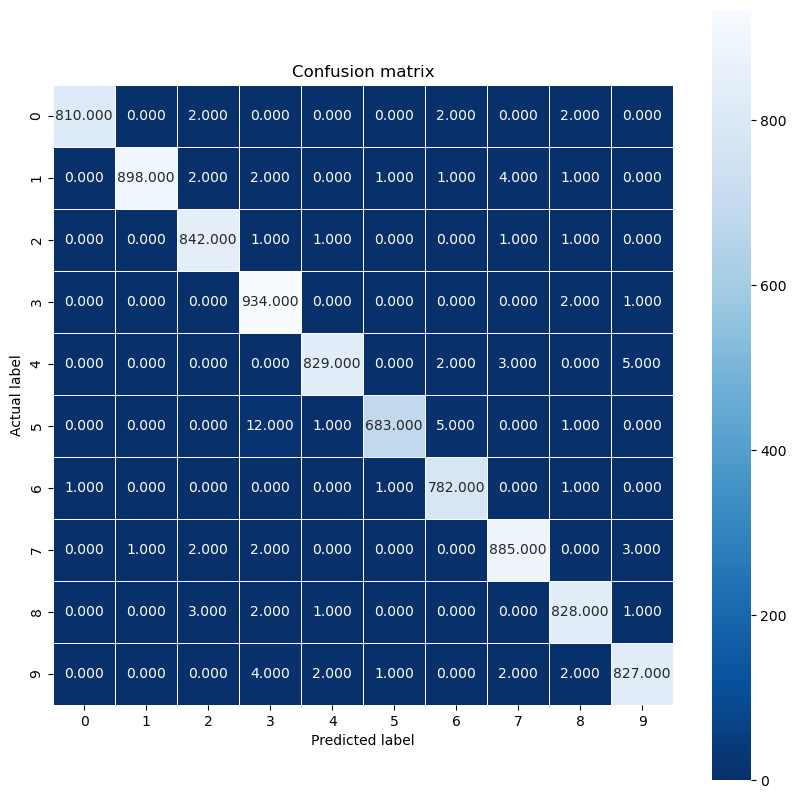

In [67]:
# Plot confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='.3f', linewidths=.5, square=True, cmap='Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion matrix') 
plt.show()
plt.savefig('confusion_matrix.png')
plt.close()